In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [28]:
series = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']

In [29]:
series.head()

0    35
1    32
2    30
3    31
4    44
Name: Count, dtype: int64

In [153]:
df = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [150]:
df.head()

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
Count    365 non-null int64
dtypes: int64(1)
memory usage: 5.7 KB


Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


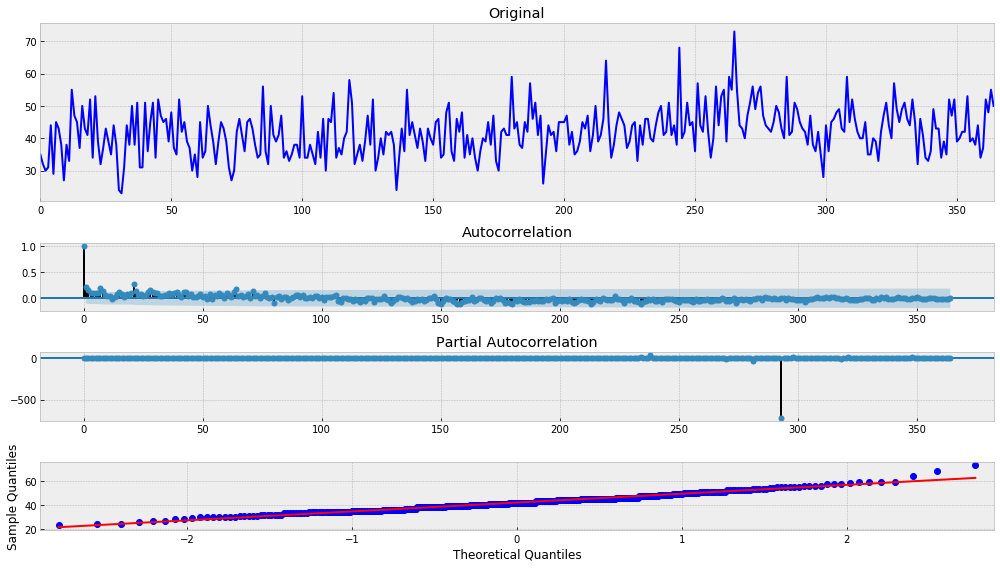

In [20]:
tsplot(series)

Можем видеть, что хотя результат Дики Фуллера позволяет отклонить гипотезу о нестационарности,qqplot неидеально совпадает с прямой линией, а на самом графике возможно прослеживается небольшой тренд + дисперсия также возможно немонотонна.

In [30]:
series_box = boxcox(series,0)

Results of Dickey-Fuller Test:
Test Statistic                  -4.353173
p-value                          0.000359
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


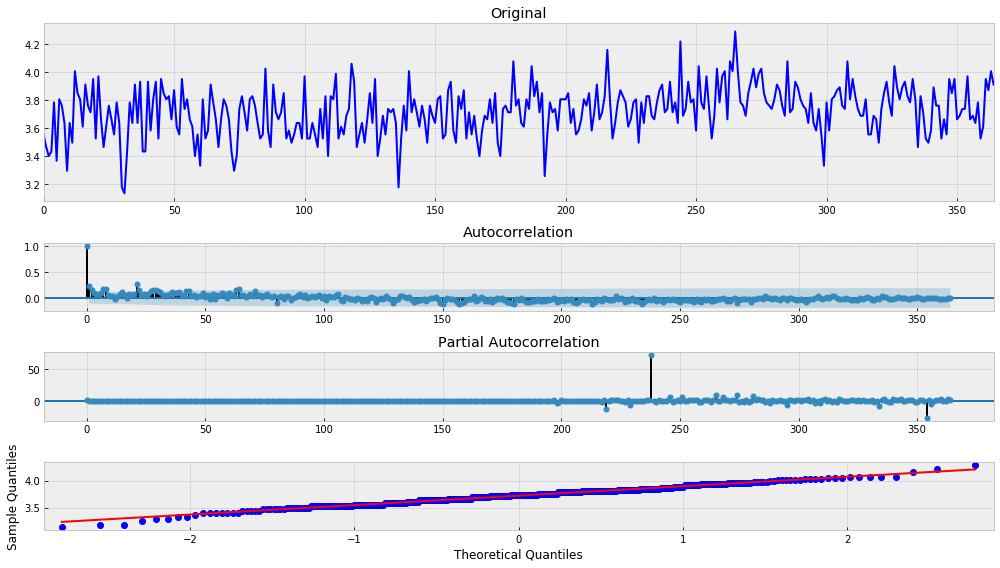

In [32]:
tsplot(series_box)

In [34]:
series_diff  = np.diff(series_box)

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


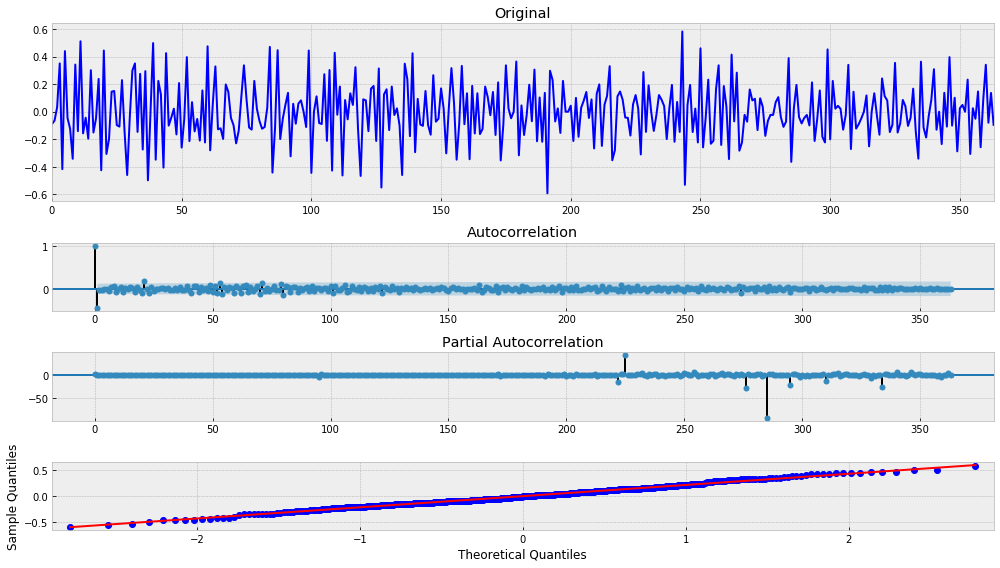

In [35]:
tsplot(series_diff)

Можем видеть, что преобразование Бокса-Кокса не очень помогло, однако, когда мы убрали тренд графики стали полностью стационарными

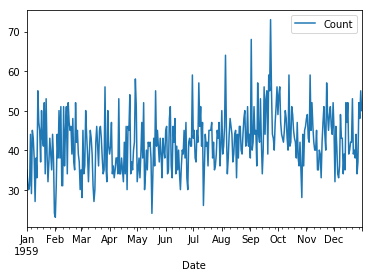

In [37]:
df.plot();

Также, возникает ощущение, что присутствует некая сезонность.

In [40]:
series_seas = series_box[7:] - series_box[:-7]

Results of Dickey-Fuller Test:
Test Statistic                -8.312073e+00
p-value                        3.765443e-13
#Lags Used                     1.400000e+01
Number of Observations Used    3.430000e+02
Critical Value (1%)           -3.449560e+00
Critical Value (5%)           -2.870004e+00
Critical Value (10%)          -2.571279e+00
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


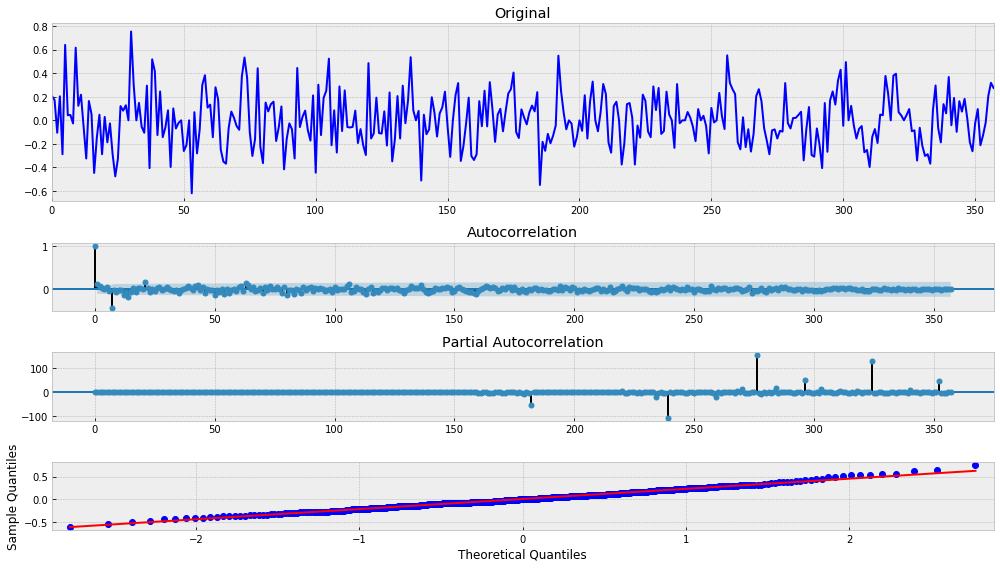

In [41]:
tsplot(series_seas)

Можем видеть, что добавления сезонного тренда также помогло. Применим сезонность дополнительно к основному тренду.

In [42]:
series_seas = series_diff[7:] - series_diff[:-7]

Results of Dickey-Fuller Test:
Test Statistic                -9.417040e+00
p-value                        5.632886e-16
#Lags Used                     1.600000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


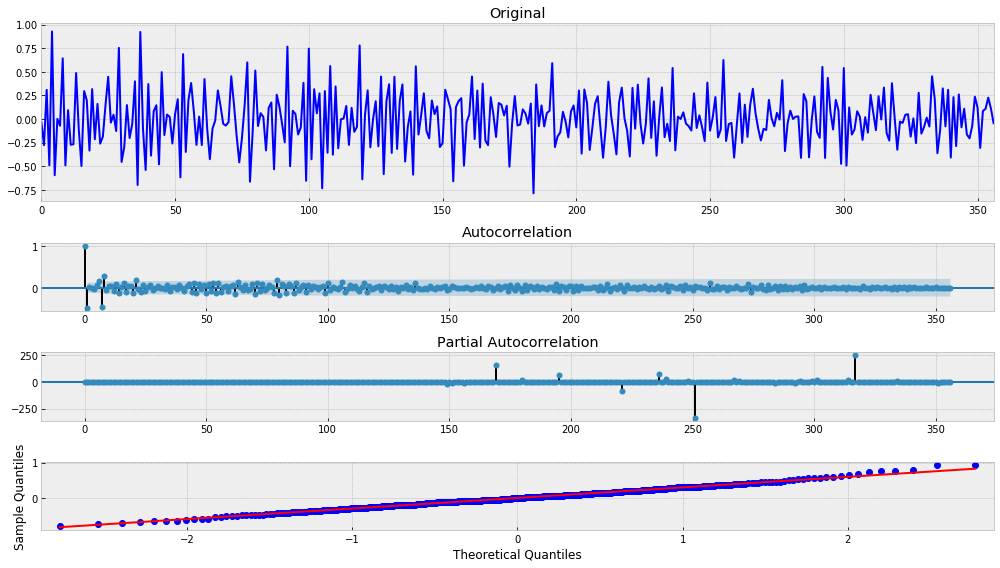

In [43]:
tsplot(series_seas)

# ARIMA

Попробуем смоделировать наш ряд ARIMA

/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/truv/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


aic: -88.94491 | order: (2, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -5.227665
p-value                          0.000008
#Lags Used                      17.000000
Number of Observations Used    339.000000
Critical Value (1%)             -3.449788
Critical Value (5%)             -2.870104
Critical Value (10%)            -2.571332
dtype: float64


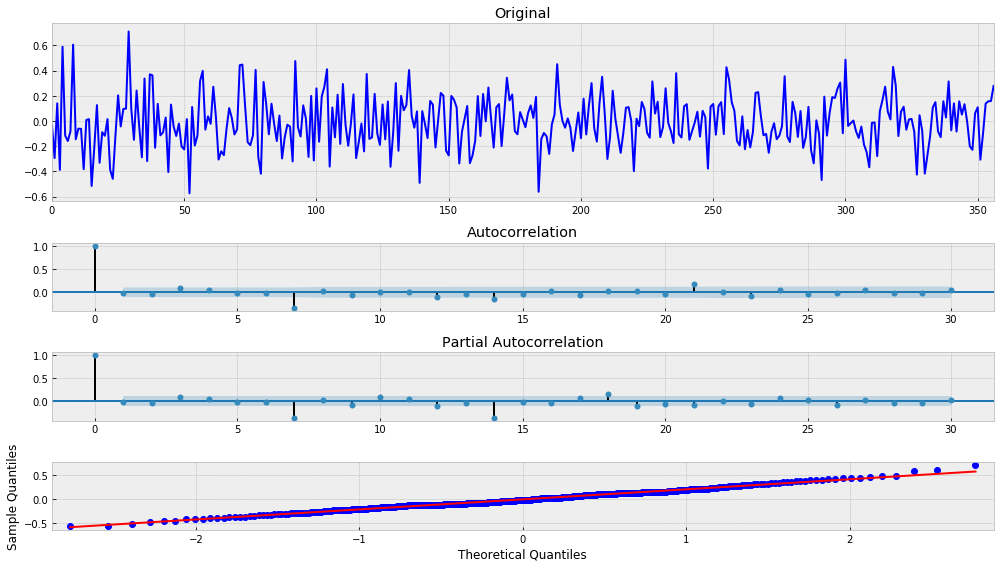

In [50]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series_seas, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Графики остатков и тест свидетельствуют о стаионарности ошибок, что подсказывает, что выбранная модель подходит к моделированию ряда. Однако, порядок MA равено нулю, это может говорить о том, что в ряде более превалирует сезонная составляющая.

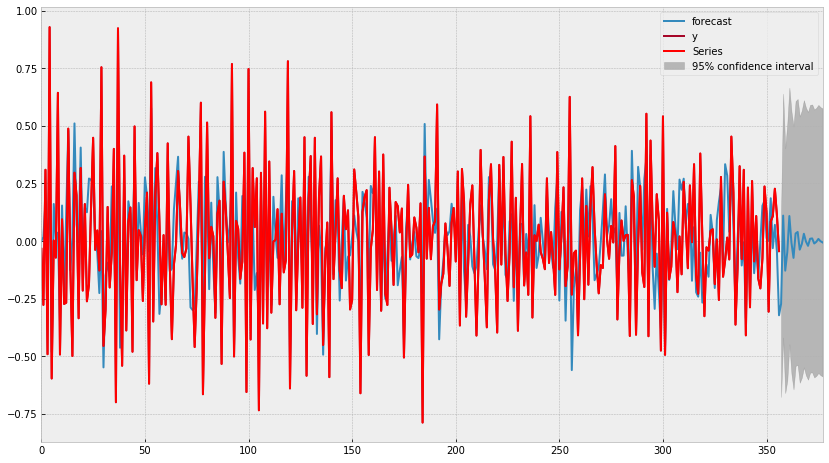

In [51]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series_seas)+20, ax=ax)
    plt.plot(series_seas, color='red', label='Series')
    plt.legend()
    plt.show()

Можем видеть,что модель скорее укадывала направлени движения, однако, не хватало размаха. Так что можно заявлять, что дисперсия предсказанных 20 значение скорее  всего будет больше.

# GARCH

In [56]:
from arch import arch_model

In [57]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(series_seas, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -60.6556
Distribution:      Standardized Student's t   AIC:                           139.311
Method:                  Maximum Likelihood   BIC:                           174.211
                                              No. Observations:                  357
Date:                      Fri, May 31 2019   Df Residuals:                      348
Time:                              08:35:19   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

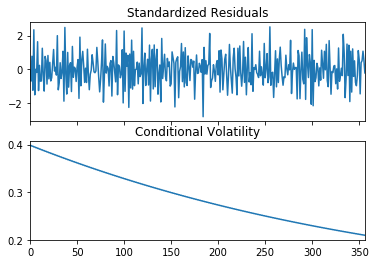

In [58]:
fig = res.plot()

Results of Dickey-Fuller Test:
Test Statistic                -9.417040e+00
p-value                        5.632886e-16
#Lags Used                     1.600000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


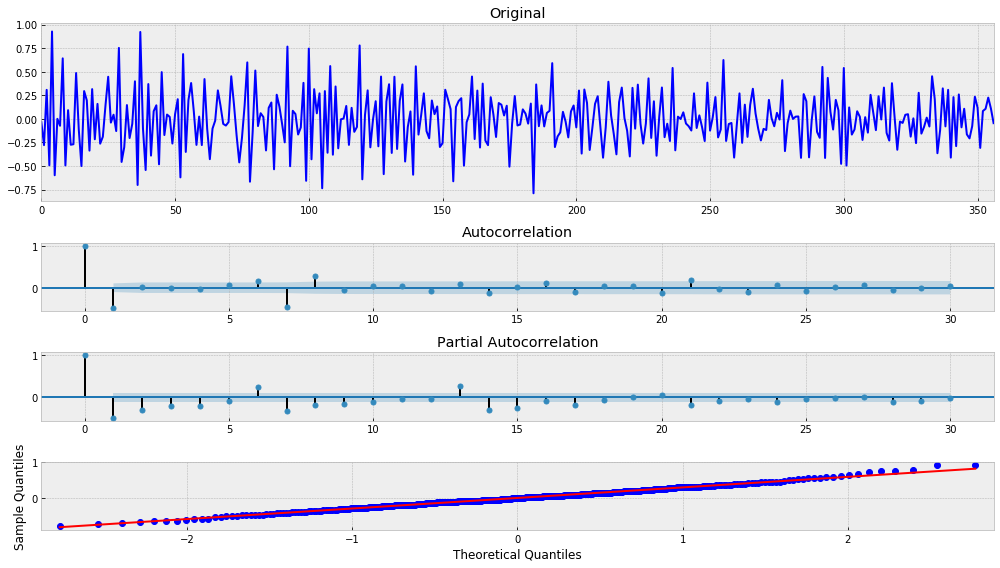

In [90]:
tsplot(res.resid, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -4.989927
p-value                          0.000023
#Lags Used                       7.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


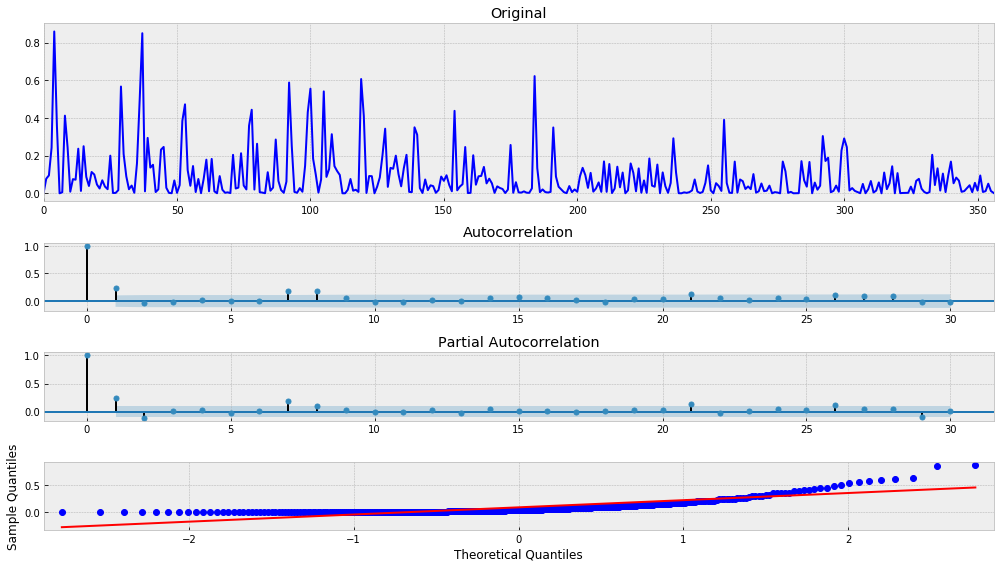

In [91]:
tsplot(res.resid**2, lags=30)

# ML

In [173]:
def prepareData(data, lag_start=5, lag_end=15, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    #добавляем день недели
    data['weekday'] = data.Date.dt.weekday
    
    #добавляем среднее за неделю
    data['mean'] = data['Count'].rolling(7).mean()
    
    #добавляем отклонение за неделю
    data['std'] = data['Count'].rolling(7).std()
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    #посчитаем тенденцию: разницу между значением прошлой недели и предыдущей
    data['diff_last_week'] = data["lag_7"].diff()

        
    data = data.dropna()
    data = data.drop(["Date"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [134]:
df.head()

,Count
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [141]:
df.reset_index(inplace=True)

In [157]:
df.Date = pd.to_datetime(df.Date)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
Date     365 non-null datetime64[ns]
Count    365 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [174]:
X_train, X_test, y_train, y_test = prepareData(df, test_size=0.3)

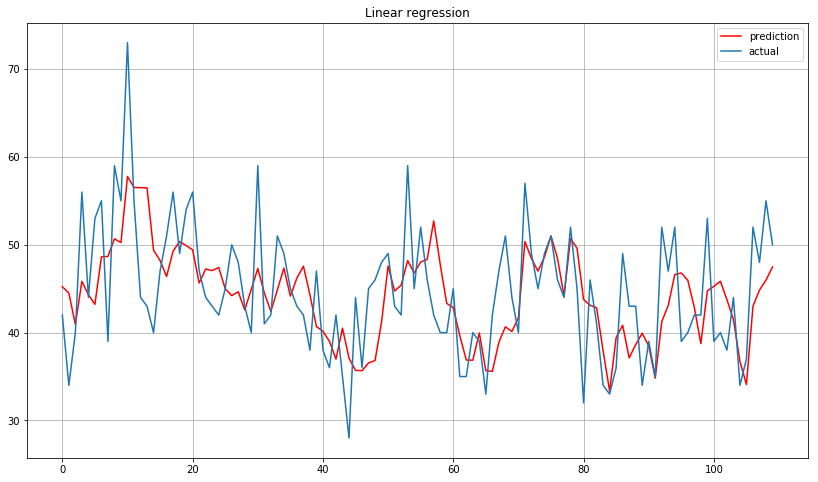

In [175]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [176]:
from sklearn.preprocessing import StandardScaler

In [179]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/home/truv/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/truv/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/truv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


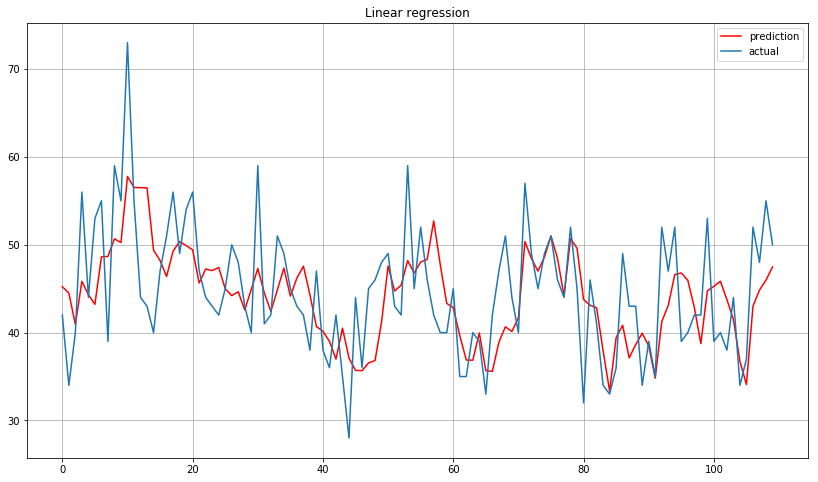

In [182]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [204]:
lr.score(X_test_scaled, y_test)

0.3214738952926006

In [188]:
from sklearn.metrics import mean_squared_log_error

In [207]:
from sklearn.metrics import mean_squared_error

In [212]:
def rmse(ytrue, ypred):
    return mean_squared_error(ytrue, ypred)

In [213]:
rmse(y_test,prediction)

35.225935070303755

In [193]:
from lightgbm import LGBMRegressor

In [194]:
mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
mdl.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [195]:
pred = mdl.predict(X_test_scaled)

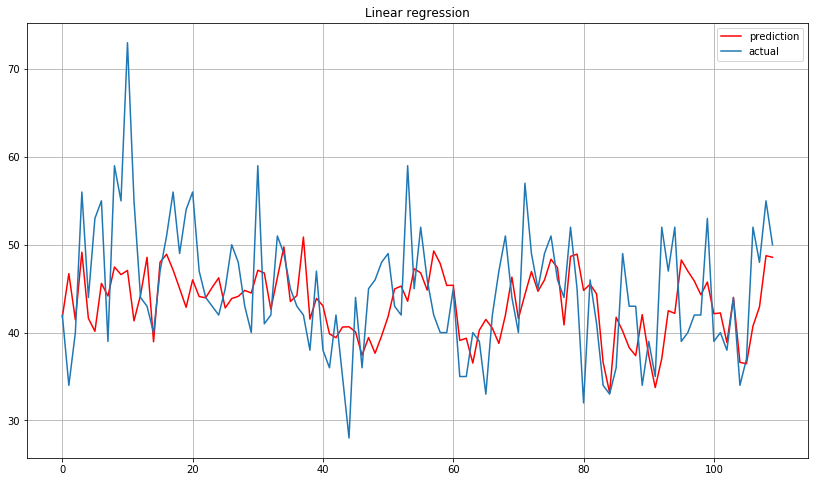

In [196]:
plt.figure(figsize=(14, 8))
plt.plot(pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [214]:
rmsle(y_test,pred)

44.72137115388808

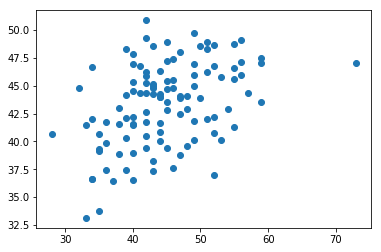

In [203]:
plt.scatter(x=y_test, y=pred );

In [206]:
from sklearn.ensemble import RandomForestRegressor

In [215]:
f = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
f.fit(X_train, y_train)
    
p = f.predict(X_test)

In [216]:
rmsle(y_test,p)

47.36090900909091

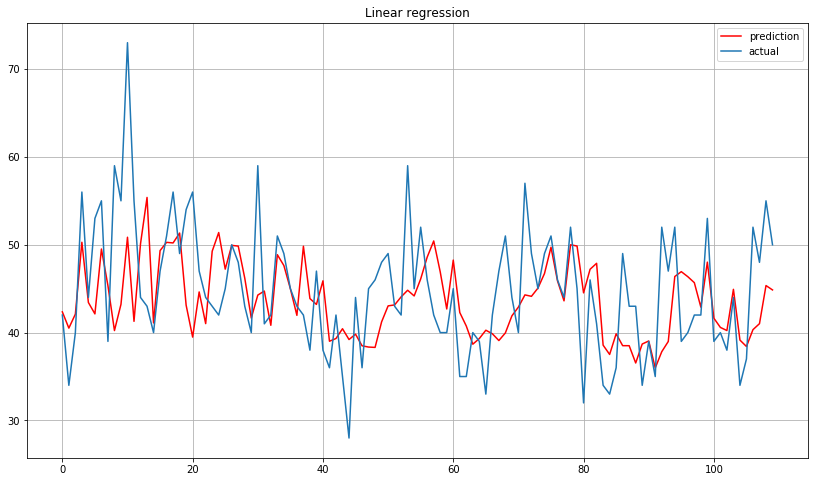

In [217]:
plt.figure(figsize=(14, 8))
plt.plot(p, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

Лучше всего себя проявила простая линейная регрессия.Она имеет меньшую ошибку и по графикам выглядт привлекательней. Попробуем добавить еще один признак - сделаем сдвиг еще на одну неделю и посчитаем разницу с предыдущей

In [218]:
def prepareData_n(data, lag_start=3, lag_end=15, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    #добавляем день недели
    data['weekday'] = data.Date.dt.weekday
    
    #добавляем среднее за неделю
    data['mean7'] = data['Count'].rolling(7).mean()
    
    #добавляем среднее за неделю
    data['mean3'] = data['Count'].rolling(3).mean()
    
    #добавляем отклонение за неделю
    data['std3'] = data['Count'].rolling(3).std()
    
    data['std7'] = data['Count'].rolling(7).std()
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    #посчитаем тенденцию: 
    data['diff_last_week'] = data["lag_7"].diff()
    
    #посчитаем тенденцию: 
    data['diff_last_14'] = data["lag_14"].diff()
    
    #посчитаем тенденцию: 
    data['diff_last_3'] = data["lag_3"].diff()

        
    data = data.dropna()
    data = data.drop(["Date"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [220]:
X_train_n, X_test_n, y_train_n, y_test_n = prepareData_n(df, test_size=0.3)

In [221]:
scaler = StandardScaler()
X_train_scaled_n = scaler.fit_transform(X_train_n)
X_test_scaled_n = scaler.transform(X_test_n)

/home/truv/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/truv/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/truv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


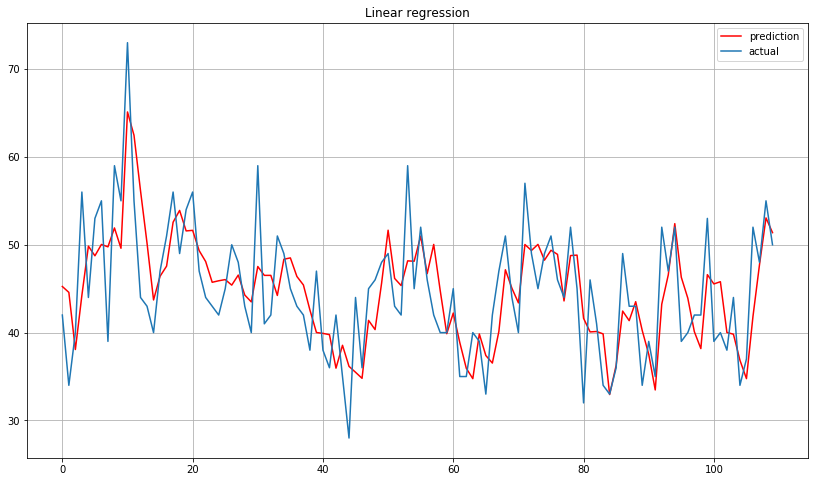

In [222]:
lr = LinearRegression()
lr.fit(X_train_scaled_n, y_train_n)
prediction = lr.predict(X_test_scaled_n)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test_n.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [223]:
rmsle(y_test_n,prediction)

25.666137995060488

In [224]:
lr.score(X_test_scaled_n, y_test_n)

0.5056158310087748

Добавление более детальной информации о тенденции, средних и отклонениях за различные промежутки времени позволило значительно улучшить результат.